# Voronoi graph
Research Notebook to create a grid using Voronoi approach.

## Imports

In [1]:
import networkx as nx
nx.__version__

import numpy as np
from scipy.spatial import Voronoi, voronoi_plot_2d
from shapely.geometry import Polygon, Point, LineString
from queue import PriorityQueue
from planning_utils import heuristic, create_grid, FLYING_ALTITUDE, SAFETY_DISTANCE
import time

%matplotlib inline

## Load Data

In [2]:
# This is the same obstacle data from the previous lesson.
filename = 'colliders.csv'
data = np.loadtxt(filename, delimiter=',', dtype='Float64', skiprows=2)
print(data)

[[-310.2389   -439.2315     85.5         5.          5.         85.5     ]
 [-300.2389   -439.2315     85.5         5.          5.         85.5     ]
 [-290.2389   -439.2315     85.5         5.          5.         85.5     ]
 ...
 [ 257.8061    425.1645      1.75852     1.292725    1.292725    1.944791]
 [ 293.9967    368.3391      3.557666    1.129456    1.129456    3.667319]
 [ 281.5162    354.4156      4.999351    1.053772    1.053772    4.950246]]


In [3]:
print('start')
grid, centers, north_offset, east_offset = create_grid(data, FLYING_ALTITUDE, SAFETY_DISTANCE)
print('done')

start
done


## Voronoi graph method

In [4]:
print('Creating Voronoi')
# Create a voronoi graph based on location of obstacle centres (2D no height)
t0 = time.time()
np_centers = np.array(centers)
voronoi_graph = Voronoi(np_centers[:,:-1])
print('Voronoi Graph with {0} nodes'.format(len(voronoi_graph.vertices)))
print('Voronoi Graph took {0} seconds to build'.format(time.time()-t0))

Creating Voronoi
Voronoi Graph with 5858 nodes
Voronoi Graph took 0.03178668022155762 seconds to build


In [5]:
import numpy.linalg as LA
from sklearn.neighbors import KDTree
from bresenham import bresenham

def create_graph_from_voronoi(voronoi_graph):
    g = nx.Graph()
    nodes = tuple(map(tuple, voronoi_graph.vertices))
    tree = KDTree(nodes)
    # Check each edge from graph.ridge_vertices for collision
    k=10
    for n1 in nodes:
        # for each node connect try to connect to k nearest nodes
        idxs = tree.query([n1], k, return_distance=False)[0]
        for idx in idxs:
            n2 = nodes[idx]
            if n2 == n1:
                continue

            hit = False
            cells = list(bresenham(int(n1[0]), int(n1[1]), int(n2[0]), int(n2[1])))
            for c in cells:
                # First check if we're off the map
                if np.amin(c) < 0 or c[0] >= grid.shape[0] or c[1] >= grid.shape[1]:
                    hit = True
                    break
                # Next check if we're in collision
                if grid[c[0], c[1]] >= FLYING_ALTITUDE + SAFETY_DISTANCE:
                    hit = True
                    break
            # If the edge does not hit on obstacle
            # add it to the list
            if not hit:
                dist = LA.norm(np.array(n2) - np.array(n1))
                g.add_edge((n1[0], n1[1], FLYING_ALTITUDE), (n2[0], n2[1], FLYING_ALTITUDE), weight=dist)

    return g, tree

print('Creating NxGraph')
t0 = time.time()
g, t = create_graph_from_voronoi(voronoi_graph)
print('Graph took {0} seconds to build'.format(time.time()-t0))

Creating NxGraph
Graph took 26.533848762512207 seconds to build


In [6]:
from utils import print_info

print_info(g, grid, north_offset, east_offset)

Graph nodes:  3672
Graph edges: 16830
Grid dimensions (921, 921), north_offset: -316, east_offset: -445 


## Save to pickle

In [7]:
from utils import save_graph_to_pickle

save_graph_to_pickle(g, grid, north_offset, east_offset, 'graph.voronoi.raw.p')

print('done')

Saving to pickle file graph.voronoi.raw.p
done


## Visualize graph

Graph nodes:  3672
Graph edges: 16830
Grid dimensions:  (921, 921)


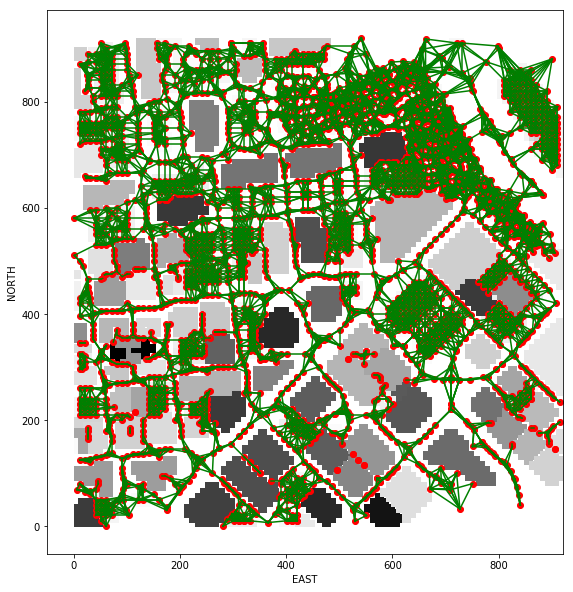

done


In [10]:
from utils import visualize_graph, print_info

print_info(g, grid, north_offset, east_offset)

visualize_graph(g, grid)

print('done')

## A*

Start:  2011
Goal:  3163
29 [(661.7294403114123, 722.7449867635834, 20), (655.8275778329944, 721.145346792545, 20), (654.2241658263971, 730.5802812821047, 20), (649.89749358267, 731.5993435979849, 20), (650.3369162432708, 739.5119542581489, 20), (648.1696686558063, 741.2909529598061, 20), (649.5585693452847, 748.8800530773987, 20), (643.0921539491821, 753.4543675555328, 20), (637.8795118734228, 751.3871600134413, 20), (629.375260231001, 750.678402293875, 20), (618.6653606374481, 738.6412255623111, 20), (613.9502422784462, 735.2806724305797, 20), (599.5624491517694, 734.9220286826883, 20), (580.7610999999999, 720.7685, 20), (570.7610999999999, 710.7685, 20), (550.7610999999999, 690.7685, 20), (540.7610999999999, 680.7685, 20), (520.7610999999999, 660.7685, 20), (498.2611, 643.2685, 20), (490.7611, 650.7685, 20), (478.7611, 668.7685, 20), (460.7611, 660.7685, 20), (450.7611, 650.7685, 20), (450.7611, 640.7685, 20), (450.7611, 630.7685, 20), (440.7611, 620.7685, 20), (430.7611, 610.7685, 

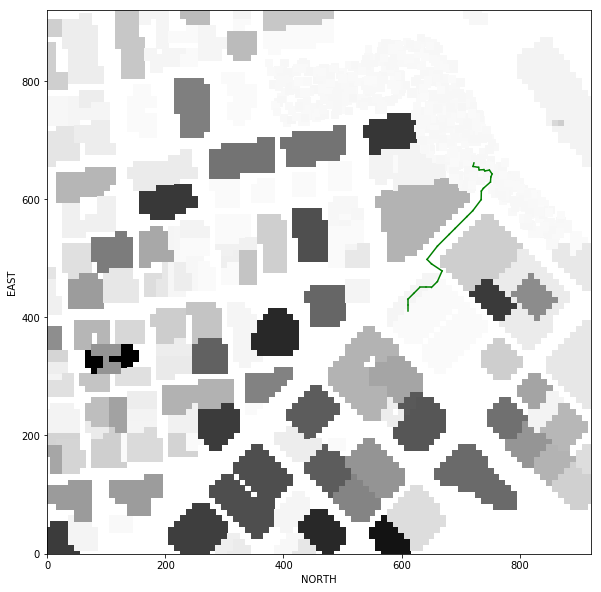

done


In [7]:
from utils import perform_astar

perform_astar(g, grid)

print('done')